<a href="https://colab.research.google.com/github/AlexandraLutaya/heart_deasese_models/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B0%D0%BB%D0%B8%D1%87%D0%B8%D1%8F_%D1%81%D0%B5%D1%80%D0%B4%D0%B5%D1%87%D0%BD%D0%BE_%D1%81%D0%BE%D1%81%D1%83%D0%B4%D0%B8%D1%81%D1%82%D1%8B%D1%85_%D0%B7%D0%B0%D0%B1%D0%BE%D0%BB%D0%B5%D0%B2%D0%B0%D0%BD%D0%B8%D0%B9_%D0%BD%D0%B0_%D0%BE%D1%81%D0%BD%D0%BE%D0%B2%D0%B5_%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA_%D0%BF%D0%B0%D1%86%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Прогнозирование наличия сердечно-сосудистых заболеваний на основе характеристик пациентов

Датасет представляет собой .csv файл, содержащий следующие поля:

* id: идентификатор для каждого человека в наборе данных;
* age: возраст человека (в днях);
* gender: пол (1 для женщин, 2 для мужчин);
* height: рост в сантиметрах;
* weight: вес в килограммах;
* ap_hi: систолическое артериальное давление (измеряется в мм рт.ст.);
* ap_lo: диастолическое артериальное давление (измеряется в мм рт.ст.);
* cholesterol: уровень холестерина (1 – в норме, 2 – выше нормы, 3 –
значительно выше нормы);
* gluc: уровень глюкозы (1 – в норме, 2 – выше нормы, 3 – значительно выше
нормы);
* smoke: курит ли человек (0 – нет, 1 – да);
* alco: употребляет ли человек алкоголь (0 – нет, 1 – да);
* active: является ли человек физически активным (0 – нет, 1 – да);
* cardio: наличие сердечно-сосудистых заболеваний (0 – нет, 1 – да).

##Загрузка библиотек и написание собственных функций

In [1]:
pip install --upgrade gdown

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb


from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_score, recall_score
from sklearn.inspection import permutation_importance

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore', module='pandas')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#функция для изучения данных на аномальные значения и попуски
#функция принимает на вход DataFrame, выводит текстовые сообщения на консоль
def anomaly(data):
  #сли передан Series, преобразуем его в DataFrame
  if isinstance(data, pd.Series):
    data = data.to_frame()
  #выводим размер датасета
  print(f'Размер файла:{data.shape}')
  print('-'*100)
  #для вывода всех столбцов создаем цикл
  #выделяем в отдельную переменную названия столбцов
  column_data= data.columns
  #циклом перебираем все значения и выводим данные
  for c in column_data:
    #выводим все уникальные значения
    print(f'Уникальные значения показателя: {c}')
    print(data[c].unique())
    #считаем количество уникальных значений
    print(f'Количество уникальных значений: {data[c].nunique()}')
    #считаем количество всех значений
    print(f'Количество всех значений: {data[c].count()}')
    #считаем количество пропусков
    print(f'Количество пропусков в столбце {c}: {data[c].isna().sum()}')
    print('-'*100)

In [4]:
#функция для оценки пропусков в данных
#функция принимает на вход DataFrame, выводит текстовые сообщения на консоль
def nan_counts(df):
  #считаем количество пропусков в строке
  nan_counts = df.isna().sum(axis=1)
  #проверяем, какие строки имеют более половины NaN
  half_nan_rows = nan_counts > len(df.columns) / 2
  #количество строк с более чем половиной NaN
  num_half_nan_rows = half_nan_rows.sum()
  #вывод результатов
  print(f"\nОбщее количество строк с более чем половиной NaN: {num_half_nan_rows}")

In [5]:
#функция для исследовательского анализа количественных данных
#функция принимает на вход DataFrame (количественные данные), выводит графики на консоль
def analisys_num(data):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    #настраиваем построение гистограммы
    axes[0].hist(data.dropna(), bins=20)
    axes[0].set_title('Гистограмма показателя')
    axes[0].set_xlabel('Значения показателя')
    #визуально выводим среднее значение и медиану
    axes[0].axvline(data.median(), color='b', linestyle='dashed', linewidth=2)
    axes[0].axvline(data.mean(), color='r', linestyle='solid', linewidth=2)
    axes[0].legend(['Медиана', 'Среднее', 'Мода'], prop={'size': 6})

    #постройка боксплота для данных
    axes[1].set_title('Боксплот показателя')
    axes[1].boxplot(data.dropna())
    #настройка скрипичной диаграммы
    axes[2].set_title('Скрипичная диаграмма показателя')
    axes[2].violinplot([data.dropna()], vert=False, widths=0.75,
                       showmeans=True, showmedians=True)
    plt.tight_layout()
    plt.show()
    #выводим статистику по показателю
    print('Показатели описательной статистики')
    print(data.describe())
    print(f'Мода в данных по показателю: {data.mode()}')

In [6]:
#функция для исследовательского анализа качественных данных с использованием круговой диаграммы
#функция принимает данные и считает их количество внутри каждого уникального значения,
#после выводит круговой график
#функция принимает на вход DataFrame, выводит графики на консоль
def analisys_cat_pie(data, labels=None):
    if labels is not None:
      data = data.map(labels)

    data.value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(5, 5))
    plt.title('Круговая диаграмма показателя', size=10)
    plt.show()

In [7]:
#функция для исследовательского анализа качевтенных данных с использованием столбчатой диаграммы
#функция принимает данные и считает их количество внутри каждого уникального значения,
#после выводит столбчатую диаграмму
#функция принимает на вход DataFrame, выводит графики на консоль
def analisys_cat_plot(data):
    data.value_counts(ascending=True).plot(kind='bar', alpha=0.8)
    plt.title('Столбчатая диаграмма', size=15)
    plt.xlabel('Количество', size=12)
    plt.ylabel('Значения', size=12)
    plt.show()

In [8]:
#функция для вывода графика Lmplot
#функция принимает датасет и названия столбцов, по которым надо построить график
#функция принимает на вход DataFrame, выводит графики сообщения на консоль
def grafic(data, x, y):
    sns.lmplot(x=x, y=y, data=data)
    plt.title(f'Зависимость показателя {y} от показателя {x}', size=10)
    plt.xlabel(f'Показатель {x}', size=8)
    plt.ylabel(f'Показатель {y}', size=8)
    plt.show()

In [9]:
#функция для построения гистограммы для сравнения распространения признака в двух группах
def plot_grouped_data(dataframe, group_cols, rename_dict=None):
    grouped_data = dataframe.groupby(group_cols).size().unstack(fill_value=0)

    if rename_dict is not None:
        grouped_data.rename(columns=rename_dict.get('columns'), index=rename_dict.get('index'), inplace=True)

    plt.figure(figsize=(10, 6))
    grouped_data.plot(kind='bar', stacked=True, colormap='tab10')

    plt.xlabel(f'Категория {group_cols[0]}')
    plt.ylabel('Количество записей')
    plt.title(f'{group_cols[0]} vs {group_cols[1]}')
    plt.legend(title=f'{group_cols[1]}', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [10]:
#напишем функцию для общей оценки эффективности модели на тестовых данных байесовского классификатора
def score_model_gnb(model, X_test, y_test):
  print('Оценка ROC-AUC на тестовых данных для лучшей модели')
  #получаем массив вероятностей принадлежности объектов к каждому классу и выбираем только положительные реультаты
  probs = model.predict_proba(X_test)[:, 1]
  #вычисляем ложноположительные, истинноположительные и пороги
  fpr, tpr, _ = roc_curve(y_test, probs)
  #вычисляем площадь под ROC-кривой
  roc_auc = auc(fpr, tpr)
  print(f'Значение ROC-AUC на тестовых данных: {roc_auc:.4f}')
  #настраиваем график
  plt.figure(figsize=(7, 6))
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Доля ложноположительных (FPR)')
  plt.ylabel('Доля истинноположительных (TPR)')
  plt.title('График ROC')
  plt.legend(loc="lower right")
  plt.show()

  print('Построение матрицы ошибок для лучшей модели')
  #получаем предсказание
  preds = model.predict(X_test)
  #получаем матрицу
  cm = confusion_matrix(y_test, preds)
  #натсраиваем график
  plt.figure(figsize=(7, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Предсказанные значения')
  plt.ylabel('Истинные значения')
  plt.title('Матрица ошибок')
  plt.show()

In [11]:
#напишем функцию для общей оценки эффективности модели на тестовых данных
def score_model(model, X_test, y_test):
  print('Оценка ROC-AUC на тестовых данных для лучшей модели')
  #получаем массив вероятностей принадлежности объектов к каждому классу и выбираем только положительные реультаты
  probs = model.predict_proba(X_test)[:, 1]
  #вычисляем ложноположительные, истинноположительные и пороги
  fpr, tpr, _ = roc_curve(y_test, probs)
  #вычисляем площадь под ROC-кривой
  roc_auc = auc(fpr, tpr)
  print(f'Значение ROC-AUC на тестовых данных: {roc_auc:.4f}')
  #настраиваем график
  plt.figure(figsize=(7, 6))
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Доля ложноположительных (FPR)')
  plt.ylabel('Доля истинноположительных (TPR)')
  plt.title('График ROC')
  plt.legend(loc="lower right")
  plt.show()

  print('Построение матрицы ошибок для лучшей модели')
  #получаем предсказание
  preds = model.predict(X_test)
  #получаем матрицу
  cm = confusion_matrix(y_test, preds)
  #натсраиваем график
  plt.figure(figsize=(7, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Предсказанные значения')
  plt.ylabel('Истинные значения')
  plt.title('Матрица ошибок')
  plt.show()

  print('Важность признаков')
  #получим важность признаков
  importances = model.feature_importances_
  #представим важность прзнаков в датафрейм
  features_df = pd.DataFrame({
      'Feature': X_test.columns,
      'Importance': importances})
  #сортируем признаки по важности
  features_df_sorted = features_df.sort_values(by='Importance', ascending=True)

  #настройка графика
  plt.figure(figsize=(10, 6))
  plt.barh(features_df_sorted['Feature'], features_df_sorted['Importance'])
  plt.xlabel('Важность признака')
  plt.ylabel('Признак')
  plt.title('Важность признаков в модели')
  plt.show()

##Загрузка данный и первичное изучение

In [12]:
! gdown 1qG6OR8Yai5ImcrjnKijX1-MZYixYsM9a

Downloading...
From: https://drive.google.com/uc?id=1qG6OR8Yai5ImcrjnKijX1-MZYixYsM9a
To: /content/heart diseases.xls
100% 2.94M/2.94M [00:00<00:00, 15.0MB/s]


In [13]:
heart_disease = pd.read_csv('/content/heart diseases.xls', sep=';', encoding='utf-8')

In [14]:
heart_disease.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [15]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Предварительно приведение к типу данных не нужно.

##Предобработка данных

Задачи:

1. Провести исследования данных на явные дубликаты

2. Провести исследования данных на предмет пропусков и изучить их необходимость замены или удаления.

3. Провести исследование данных на предмет неинформативных строк (строк с более, чем половина пропусков)

In [16]:
for_clean = len(heart_disease)

In [17]:
heart_disease.shape

(70000, 13)

In [18]:
anomaly(heart_disease)

Размер файла:(70000, 13)
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: id
[    0     1     2 ... 99996 99998 99999]
Количество уникальных значений: 70000
Количество всех значений: 70000
Количество пропусков в столбце id: 0
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: age
[18393 20228 18857 ... 14925 17727 17926]
Количество уникальных значений: 8076
Количество всех значений: 70000
Количество пропусков в столбце age: 0
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: gender
[2 1]
Количество уникальных значений: 2
Количество всех значений: 70000
Количество пропусков в столбце gender: 0
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: height
[168 156 16

Есть странные показатели роста, менее 100 см, так же есть отрицательные значения в столбцах с давлением и значения за 150 в диастолическом давлении. Так же для простоты восприятия переведем возраст из дней в годы.

**Возник вопрос к росту анкетируемых, т к есть рост 60 см. Возможно в сборе данных учавсвовали люди с карликовостью, но эту информацию не указали в датасете. Т к нет возможности проверить и уточнить, является ли это ошибкой или нет, предположим что в росте нет ошибки.**

In [19]:
heart_disease['age_year'] = round(heart_disease['age']/365, 0)

In [20]:
anomaly(heart_disease['age_year'])

Размер файла:(70000, 1)
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: age_year
[50. 55. 52. 48. 60. 61. 62. 54. 41. 40. 46. 58. 59. 63. 64. 57. 56. 49.
 51. 44. 65. 45. 53. 47. 42. 39. 43. 30.]
Количество уникальных значений: 28
Количество всех значений: 70000
Количество пропусков в столбце age_year: 0
----------------------------------------------------------------------------------------------------


In [21]:
#удалим столбец с возрастом в днях
heart_disease = heart_disease.drop('age', axis = 1)

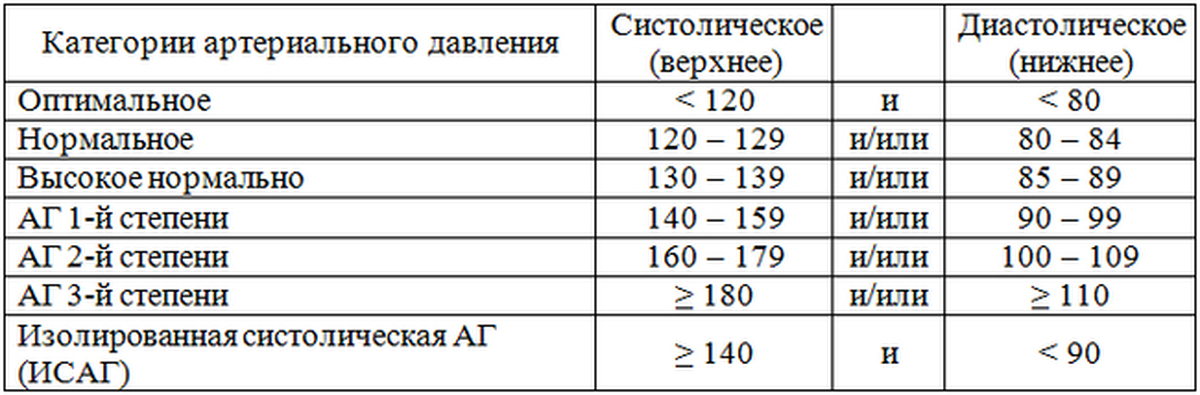

Для очистки данных от аномалий в столбцах с давлением сориентируемся на данную таблицу. Удалим в таком случае показания с диастолическим давлением выше 200, с систолическое выше 125. Так же переведем отрицательные числа, которые выглядят как опечатки в положительные.

In [22]:
heart_disease['ap_hi'] = heart_disease['ap_hi'].abs()
heart_disease['ap_lo'] = heart_disease['ap_lo'].abs()

In [23]:
heart_disease = heart_disease.query('40 <= ap_hi <= 125')
heart_disease = heart_disease.query('40 <= ap_lo <= 200')

In [24]:
after_clean = len(heart_disease)

In [25]:
heart_disease.shape

(41001, 13)

In [26]:
print(f'Процент удаленных строк состявляет {round(100*(for_clean - after_clean)/for_clean, 2)} %')

Процент удаленных строк состявляет 41.43 %


В данных нет пропусков, явные аномалии удалили сейчас.

**Рекомендация к сбору данных:** в дальнейщем необходимо внимательнее вносить данные или использовать другой подход сбора. Т к удаление аномальных значений давления привело к сокращению датасета на 41 %. В связи с этим могли быть утеряны важные паттерны.

In [27]:
heart_disease.duplicated().sum()

np.int64(0)

**Выводы:**

Была проведена предварительная оценка данных. Данные не содержат пропуски и дубликаты. Предварительно были удалены явные аномалии.

##Исследовательский анализ данных

Задачи:

1. Провести исследовательский анализ данных

2. При необхъодимости удалить грубые выбросы

3. Провести проверку данных на мультиколлинеарность

In [28]:
heart_disease.head(4)

,id,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year
0,0,2,168,62.0,110,80,1,1,0,0,1,0,50.0
4,4,1,156,56.0,100,60,1,1,0,0,0,0,48.0
5,8,1,151,67.0,120,80,2,2,0,0,0,0,60.0
8,13,1,158,71.0,110,70,1,1,0,0,1,0,48.0


In [29]:
num_column = ['height', 'weight', 'ap_hi', 'ap_lo', 'age_year']
cat_pie_column = ['gender', 'smoke', 'alco', 'active', 'cardio']
cat_column = [ 'cholesterol', 'gluc']

Исследовательский анализ показателя height


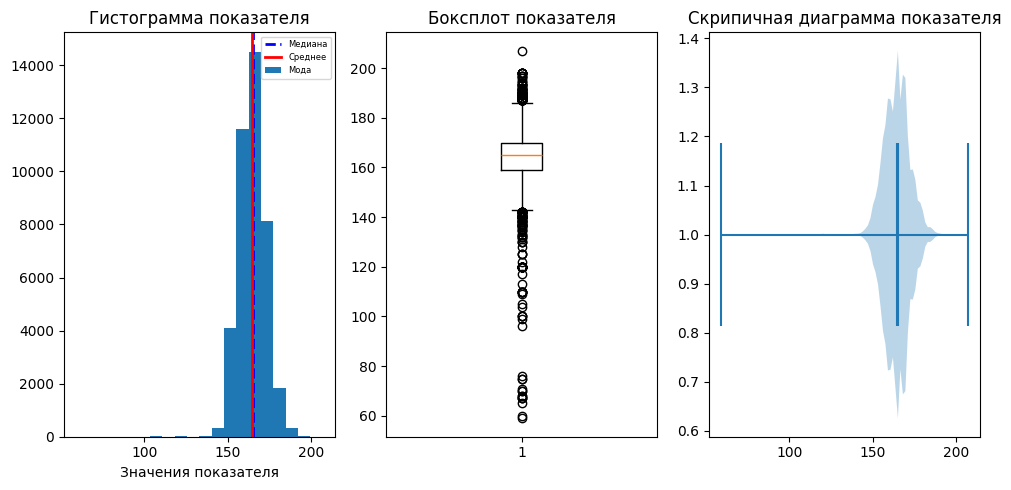

Показатели описательной статистики
count    41001.000000
mean       164.469111
std          7.986744
min         59.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        207.000000
Name: height, dtype: float64
Мода в данных по показателю: 0    165
Name: height, dtype: int64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя weight


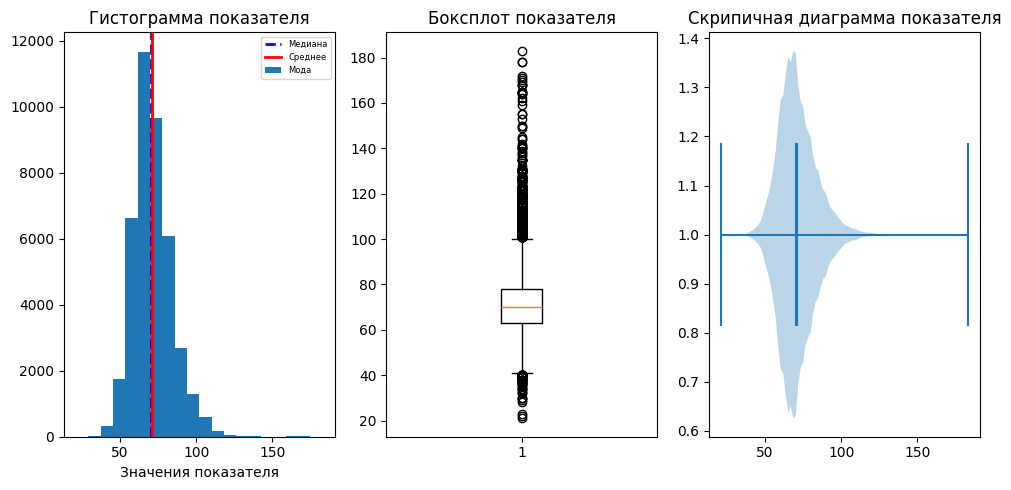

Показатели описательной статистики
count    41001.000000
mean        71.115190
std         12.724203
min         21.000000
25%         63.000000
50%         70.000000
75%         78.000000
max        183.000000
Name: weight, dtype: float64
Мода в данных по показателю: 0    65.0
Name: weight, dtype: float64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя ap_hi


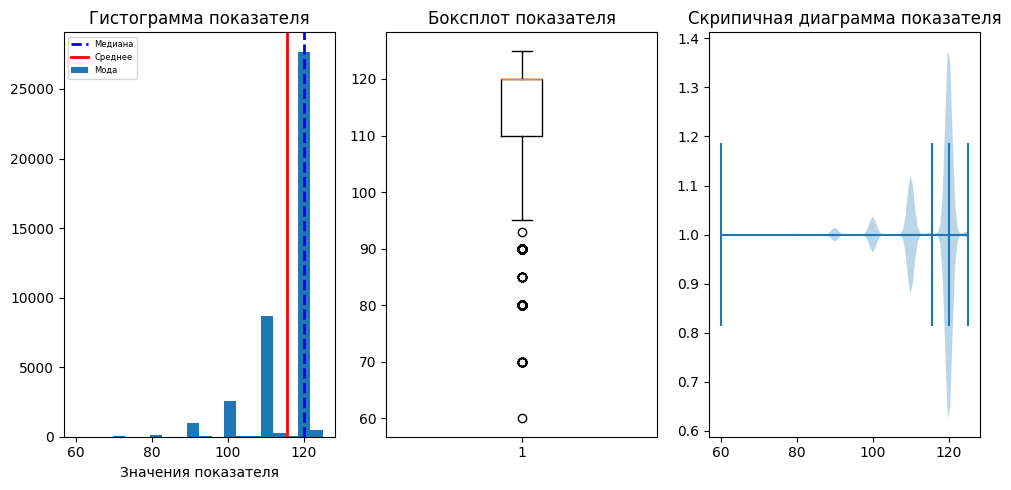

Показатели описательной статистики
count    41001.000000
mean       115.730055
std          7.539843
min         60.000000
25%        110.000000
50%        120.000000
75%        120.000000
max        125.000000
Name: ap_hi, dtype: float64
Мода в данных по показателю: 0    120
Name: ap_hi, dtype: int64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя ap_lo


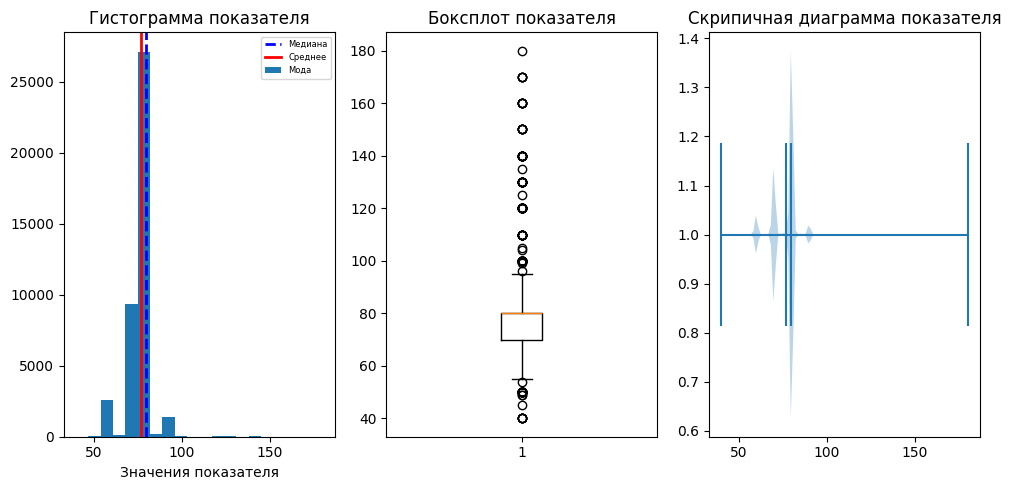

Показатели описательной статистики
count    41001.000000
mean        76.834663
std          7.137818
min         40.000000
25%         70.000000
50%         80.000000
75%         80.000000
max        180.000000
Name: ap_lo, dtype: float64
Мода в данных по показателю: 0    80
Name: ap_lo, dtype: int64
----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя age_year


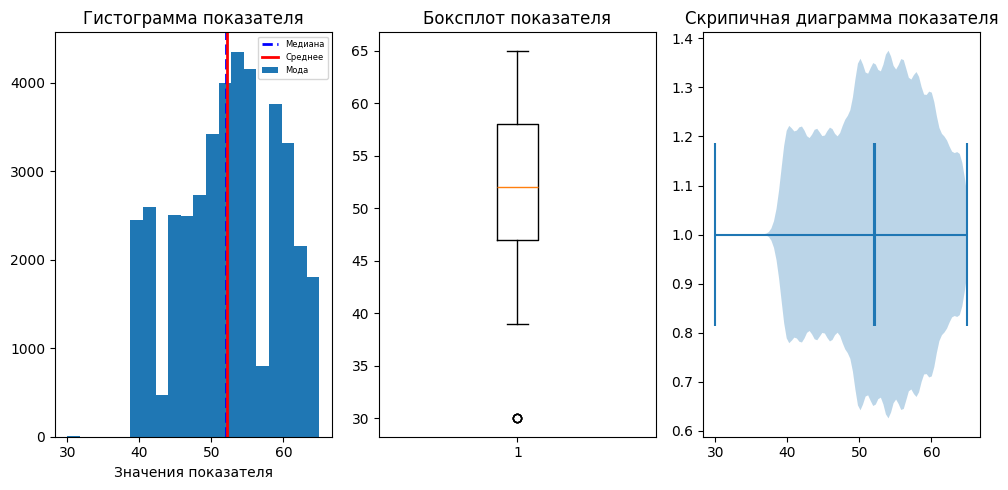

Показатели описательной статистики
count    41001.000000
mean        52.227946
std          6.829076
min         30.000000
25%         47.000000
50%         52.000000
75%         58.000000
max         65.000000
Name: age_year, dtype: float64
Мода в данных по показателю: 0    54.0
Name: age_year, dtype: float64
----------------------------------------------------------------------------------------------------


In [30]:
for col in num_column:
    print(f'Исследовательский анализ показателя {col}')
    analisys_num(heart_disease[col])
    print('-'*100)

In [31]:
old_data = len(heart_disease)

In [32]:
heart_disease = heart_disease.query('30 < age_year')
heart_disease = heart_disease.query('60 < ap_hi')

In [33]:
print(f'Процент удаленных выбросов составляет {round(100*(old_data - len(heart_disease))/old_data, 2)} %')

Процент удаленных выбросов составляет 0.01 %


Исследовательский анализ показателя gender


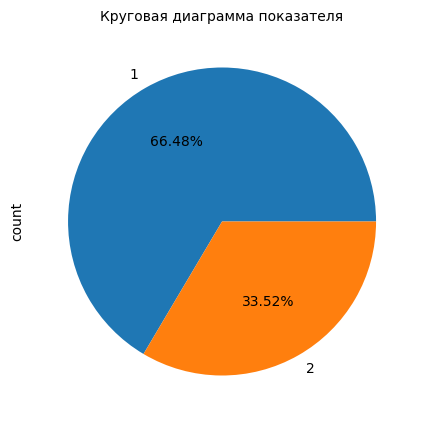

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя smoke


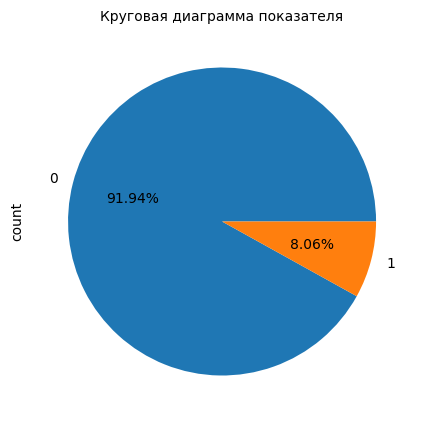

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя alco


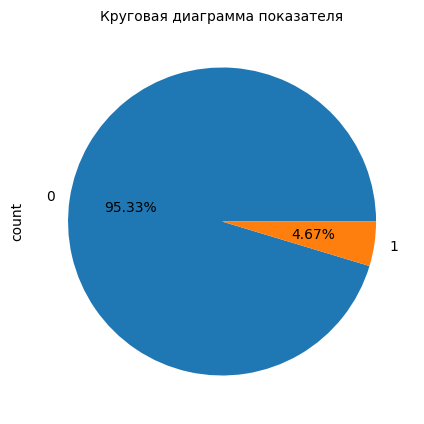

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя active


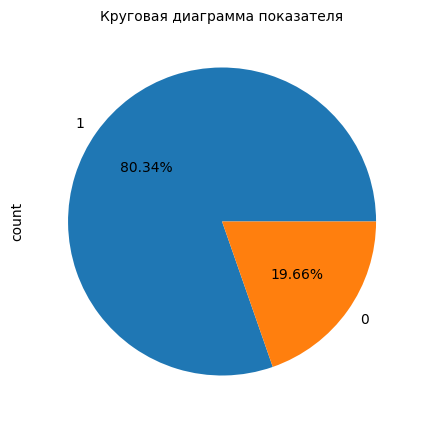

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя cardio


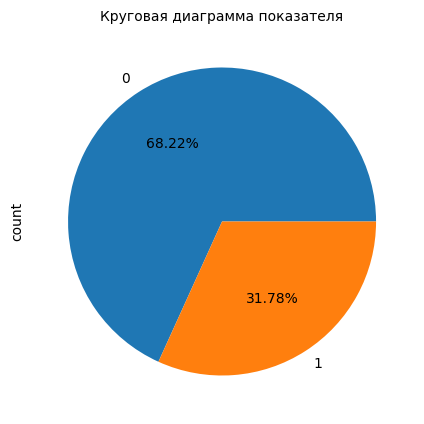

----------------------------------------------------------------------------------------------------


In [34]:
for col in cat_pie_column:
    print(f'Исследовательский анализ показателя {col}')
    analisys_cat_pie(heart_disease[col])
    print('-'*100)

Исследовательский анализ показателя cholesterol


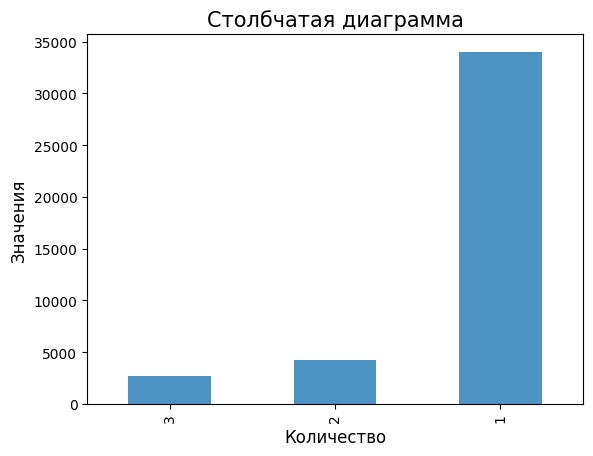

----------------------------------------------------------------------------------------------------
Исследовательский анализ показателя gluc


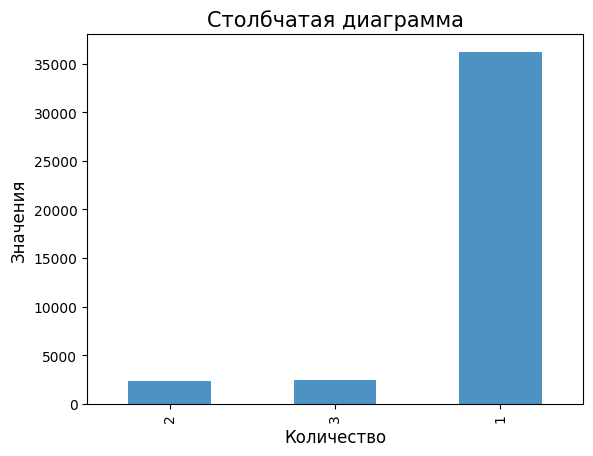

----------------------------------------------------------------------------------------------------


In [35]:
for col in cat_column:
    print(f'Исследовательский анализ показателя {col}')
    analisys_cat_plot(heart_disease[col])
    print('-'*100)

Как видно из графиков, в датасете более половины (68 %) людей без заболевания. Средний возраст 52 года, преобладают представители женского пола. В большинстве показатели крови находятся в норме и анкетируемые ведут здоровый образ жизни.

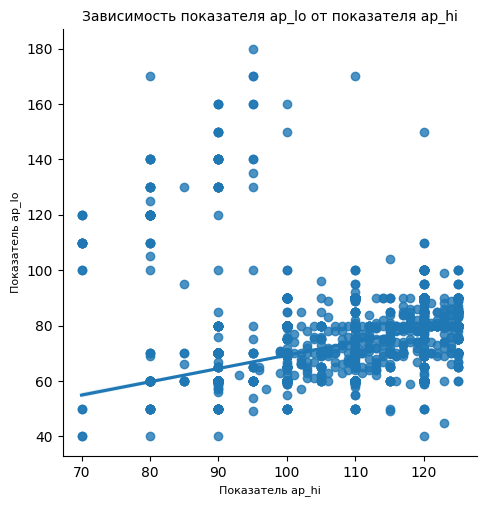

In [36]:
grafic(heart_disease, 'ap_hi', 'ap_lo')

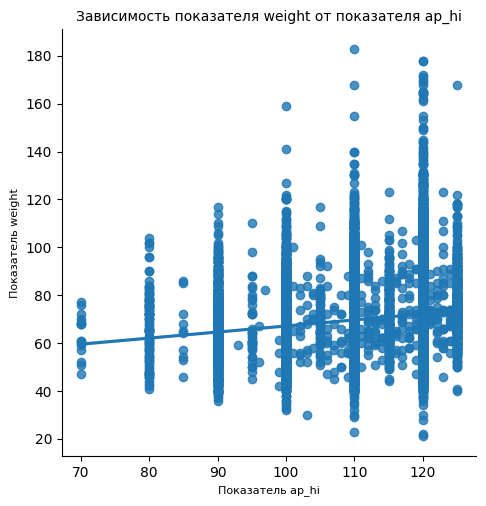

In [37]:
grafic(heart_disease, 'ap_hi', 'weight')

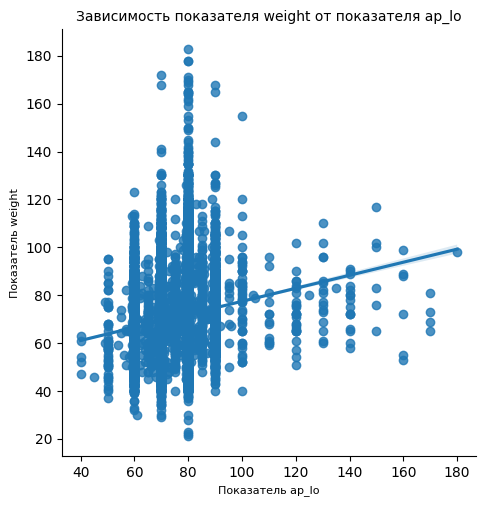

In [38]:
grafic(heart_disease, 'ap_lo', 'weight')

Наблюдается слабая связь между давлением и ростом (весом).

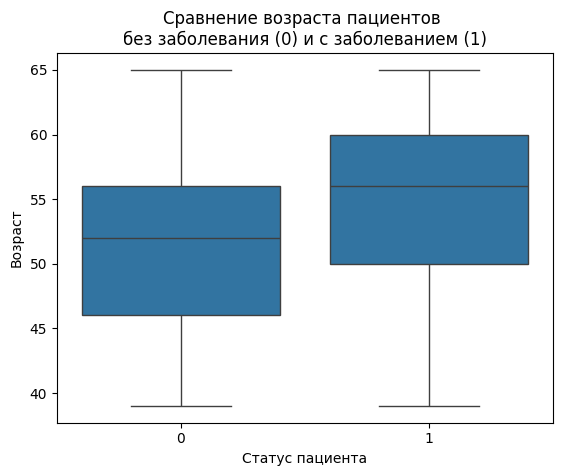

In [39]:
#изучим взамoсвязь возраста и статуса
sns.boxplot(x='cardio', y='age_year', data=heart_disease)
plt.title('Сравнение возраста пациентов \nбез заболевания (0) и с заболеванием (1)')
plt.xlabel('Статус пациента')
plt.ylabel('Возраст')
plt.show()

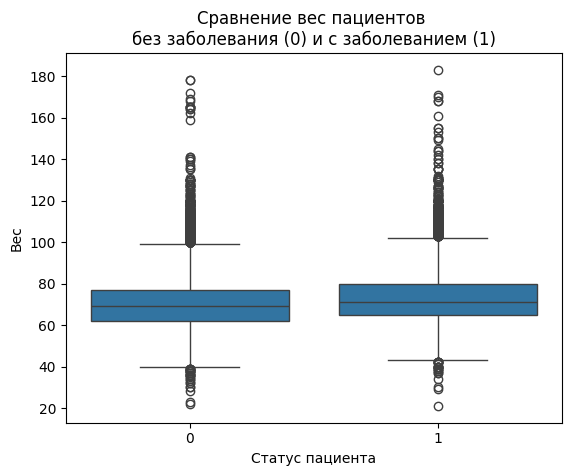

In [40]:
#изучим взамoсвязь веса и статуса
sns.boxplot(x='cardio', y='weight', data=heart_disease)
plt.title('Сравнение вес пациентов \nбез заболевания (0) и с заболеванием (1)')
plt.xlabel('Статус пациента')
plt.ylabel('Вес')
plt.show()

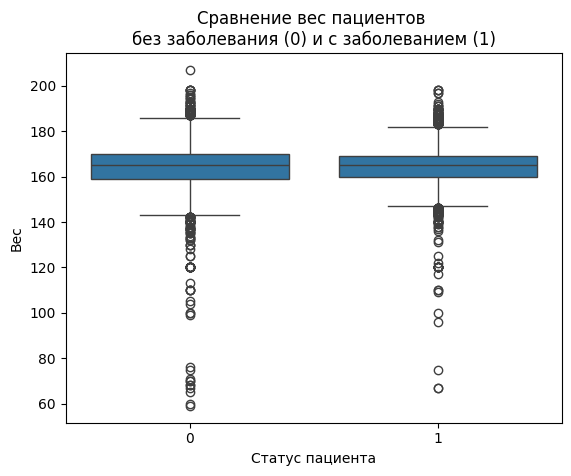

In [41]:
#изучим взамoсвязь веса и статуса
sns.boxplot(x='cardio', y='height', data=heart_disease)
plt.title('Сравнение вес пациентов \nбез заболевания (0) и с заболеванием (1)')
plt.xlabel('Статус пациента')
plt.ylabel('Вес')
plt.show()

<Figure size 1000x600 with 0 Axes>

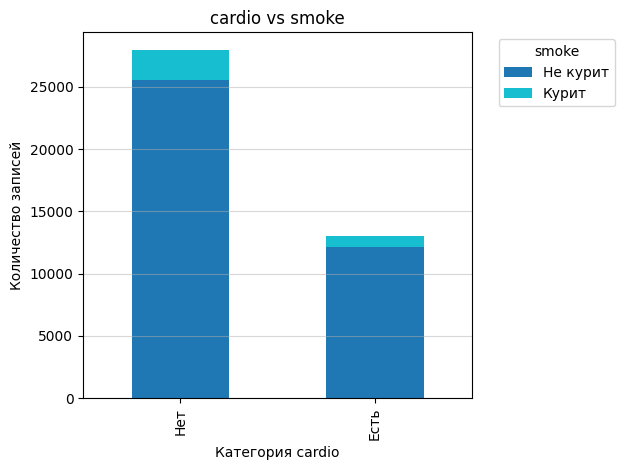

In [42]:
plot_grouped_data(heart_disease, group_cols=['cardio', 'smoke'],
    rename_dict={
        'columns': {0: 'Не курит', 1: 'Курит'},
        'index': {0: 'Нет', 1: 'Есть'}
    }
)

<Figure size 1000x600 with 0 Axes>

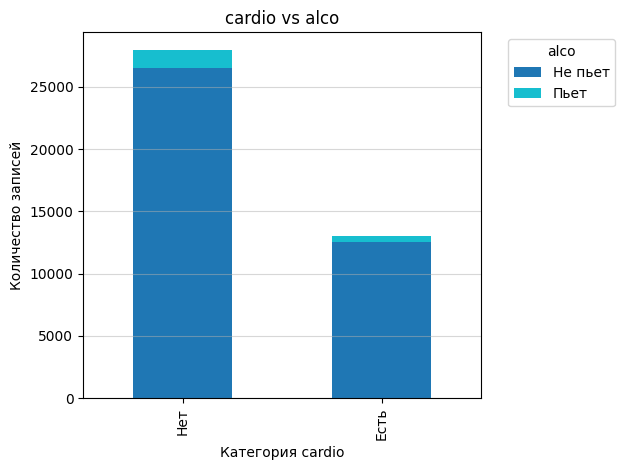

In [43]:
plot_grouped_data(heart_disease, group_cols=['cardio', 'alco'],
    rename_dict={
        'columns': {0: 'Не пьет', 1: 'Пьет'},
        'index': {0: 'Нет', 1: 'Есть'}
    }
)

<Figure size 1000x600 with 0 Axes>

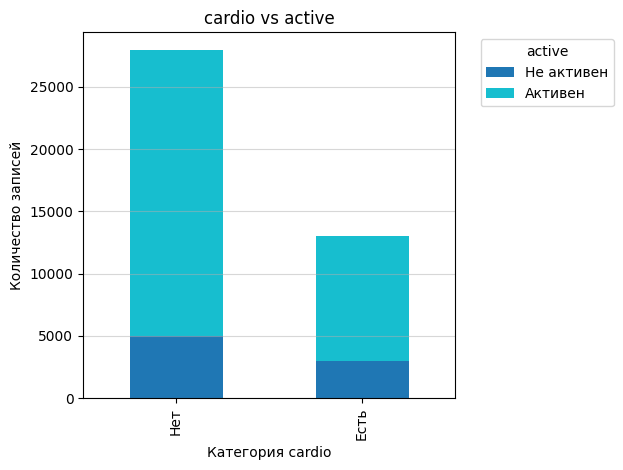

In [44]:
plot_grouped_data(heart_disease, group_cols=['cardio', 'active'],
    rename_dict={
        'columns': {0: 'Не активен', 1: 'Активен'},
        'index': {0: 'Нет', 1: 'Есть'}
    }
)

<Figure size 1000x600 with 0 Axes>

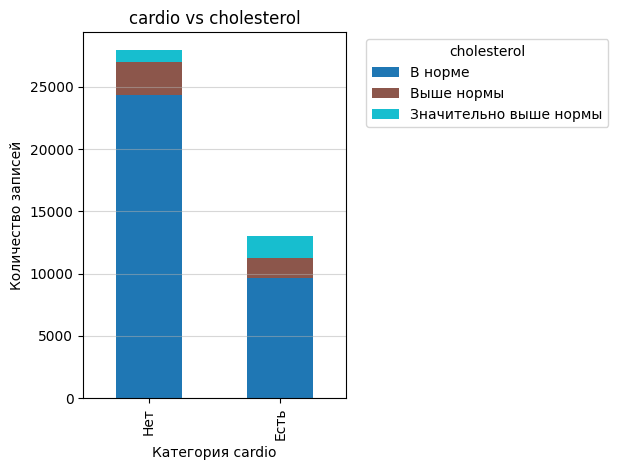

In [45]:
plot_grouped_data(heart_disease, group_cols=['cardio', 'cholesterol'],
    rename_dict={
        'columns': {1: 'В норме', 2: 'Выше нормы', 3: 'Значительно выше нормы',},
        'index': {0: 'Нет', 1: 'Есть'}
    }
)

<Figure size 1000x600 with 0 Axes>

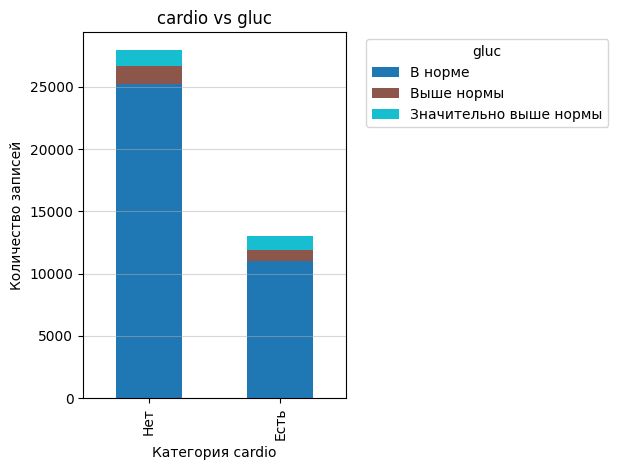

In [46]:
plot_grouped_data(heart_disease, group_cols=['cardio', 'gluc'],
    rename_dict={
        'columns': {1: 'В норме', 2: 'Выше нормы', 3: 'Значительно выше нормы',},
        'index': {0: 'Нет', 1: 'Есть'}
    }
)

Как видно из графиков, внутри выборок с заболеванием и без заболевания нет сильной разницы в показателях крови и в образе жизни.

In [47]:
corr_matrix_df = heart_disease.drop('id', axis = 1).corr()

In [48]:
#определим ранг для матрицы и ее определитель
rank = np.linalg.matrix_rank(corr_matrix_df.values)
determinant = np.linalg.det(corr_matrix_df.values)

print(f'Количество признаков {len(heart_disease.drop("id", axis=1).columns)}')
print(f'Ранг матрицы корреляций: {rank}')
print(f'Определитель матрицы корреляций: {determinant:.5f}')

Количество признаков 12
Ранг матрицы корреляций: 12
Определитель матрицы корреляций: 0.25182


Тк ранг матрицы равен количесвту признаков, то можно сделать вывод, что ни один признак нельзя выразить в виде точной линейной комбинации остальных признаков. Поскольку определитель не близок к нулю, это подтверждает, что признаки не демонстрируют серьезную мультиколлинеарность.

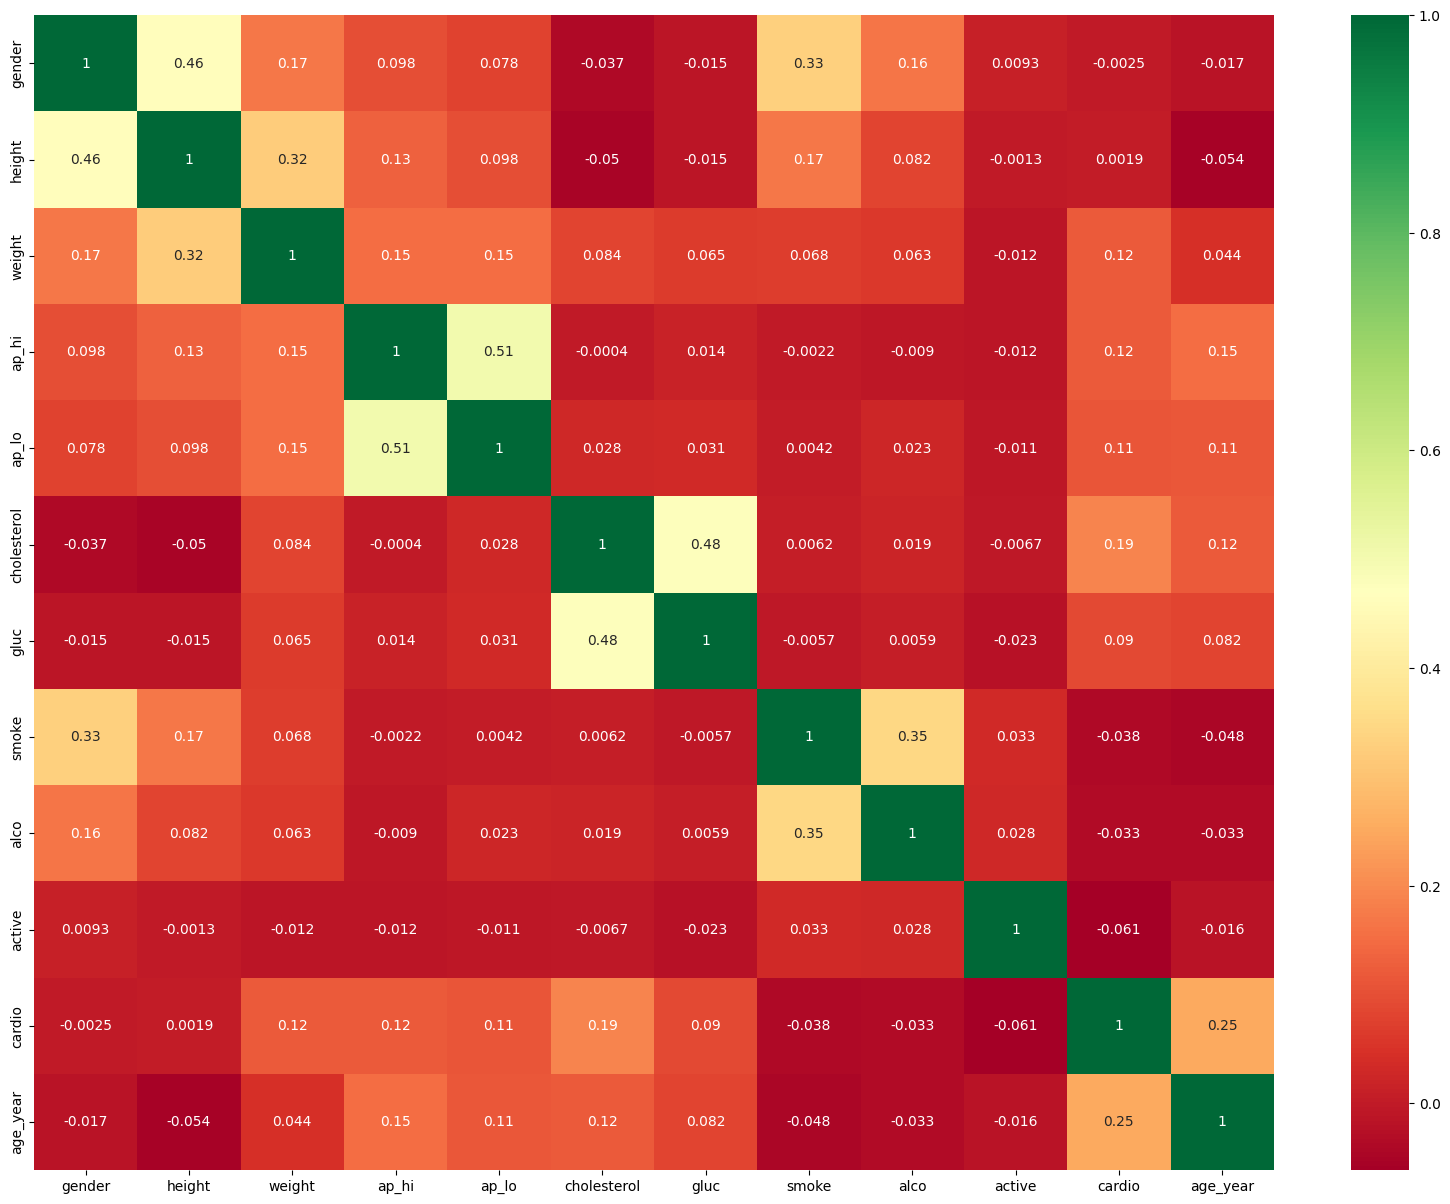

In [49]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix_df, annot=True, cmap='RdYlGn')
plt.show()

Среди признаков не наблюдается мультиколлиальность, т к нет признаков с высокой корреляционной силой. Есть признаки с средней корреляционной силой.

**Выводы:**

1. В данных представлено 68 % пациентов без заболевания сердечно-сосудистой системы. В большинстве показатели крови находятся в норме, а пациенты ведут здоровый образ жизни.

2. Зависимостей показателей крови и давления от веса не обнаружено.

3. Мультиколлинеальность в данных не обнаружена.

4. Сильный корреляционных связей у целевого признака с входыми не обнаружена, но есть обратная связь наличия заболевания с полом и активностью.

##Предподготовка данных

In [50]:
#объявим переменные
RANDOM_STATE = 42
TEST_SIZE = 0.25

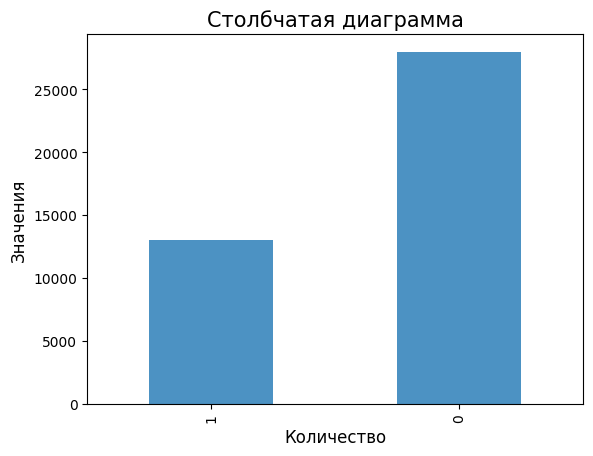

In [51]:
analisys_cat_plot(heart_disease['cardio'])

Так как распределение не равномерное, в данных соотношение больной:здоровый примерно 1:2. При разделении на тестовые и обучающие выборки нужно будет учесть стратификацию.

In [52]:
y = heart_disease['cardio']
X = heart_disease.drop(['id', 'cardio'], axis = 1)

In [53]:
def standardize(data):
    # найдем среднее значение каждого признака
    mean_X = np.mean(data, axis=0)

    # расчитаем стандартное отклонение
    std_X = np.std(data, axis=0)

    # стандартизуем по формуле: (значение i минус среднее значение) деленное на стандартное отклонение
    standardized_data = (data - mean_X) / std_X

    return standardized_data

In [54]:
for col in num_column:
  X[col]=standardize(X[col])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                    random_state= RANDOM_STATE, stratify=y)

**Выводы:** Была проведена предподготовка данных и проведена стандартизация данных ручным способом.

##Обучение и выбор лучшей модели

###Обучение наивного байесовского классификатора

Так как наши данные являются числовыми, а целью - бинарная классификация, то нам подойдет модел гауссова наивного байеса.

In [56]:
GNB = GaussianNB()

In [57]:
GNB_param = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

In [58]:
%%time
random_search_GNB = RandomizedSearchCV(
    estimator=GNB,
    param_distributions=GNB_param ,
    n_iter=4,
    cv=5,
    scoring='roc_auc')

random_search_GNB.fit(X_train, y_train)
GNB_best = random_search_GNB.best_estimator_
best_score_GNB = round(random_search_GNB.best_score_, 4)

print('Лучшая модель и её параметры:\n\n', GNB_best)
print('Параметры лучшей модели:\n', random_search_GNB.best_params_)
print(f'\n\nМетрика ROC-AUC на кросс-валидационной выборке:', best_score_GNB)

Лучшая модель и её параметры:

 GaussianNB(var_smoothing=1e-10)
Параметры лучшей модели:
 {'var_smoothing': 1e-10}


Метрика ROC-AUC на кросс-валидационной выборке: 0.6766
CPU times: user 400 ms, sys: 4.92 ms, total: 405 ms
Wall time: 417 ms


Оценка ROC-AUC на тестовых данных для лучшей модели
Значение ROC-AUC на тестовых данных: 0.6718


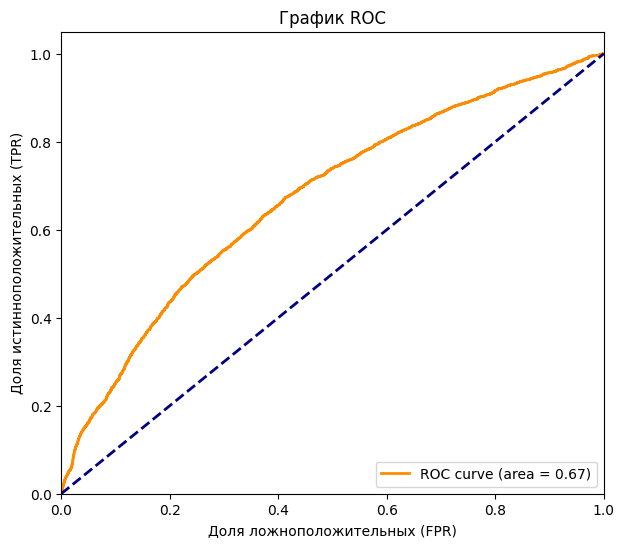

Построение матрицы ошибок для лучшей модели


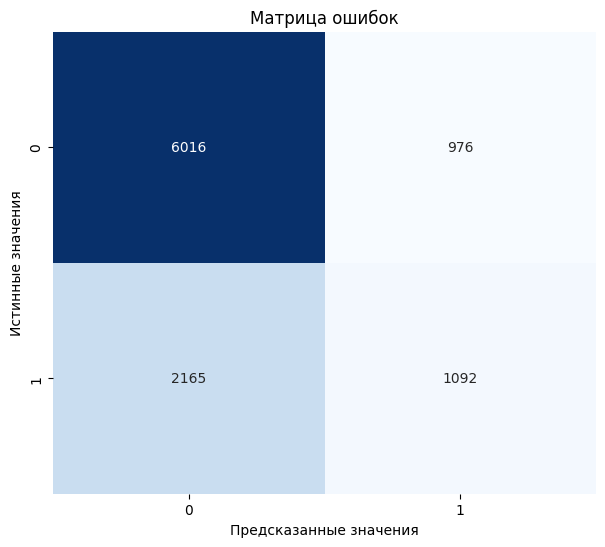

In [59]:
score_model_gnb(GNB_best, X_test, y_test)

Для наивного байесовского классификатора значение метрик на валидационных данных и тестовых равны 0.6766 и 0.6718 соотвественно.

###Обучение решающего дерева

####Обучение дерева решений без гиперпараметров

In [60]:
base_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [61]:
scores = cross_val_score(base_tree, X_train, y_train, cv=5, scoring='roc_auc')

In [62]:
mean_cv_auc = scores.mean()
std_cv_auc = scores.std()
print(f"Средняя метрика ROC-AUC на кросс-валидации: {mean_cv_auc:.4f}, std: {std_cv_auc:.4f}")

Средняя метрика ROC-AUC на кросс-валидации: 0.5561, std: 0.0043


In [63]:
base_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Оценка ROC-AUC на тестовых данных для лучшей модели
Значение ROC-AUC на тестовых данных: 0.5725


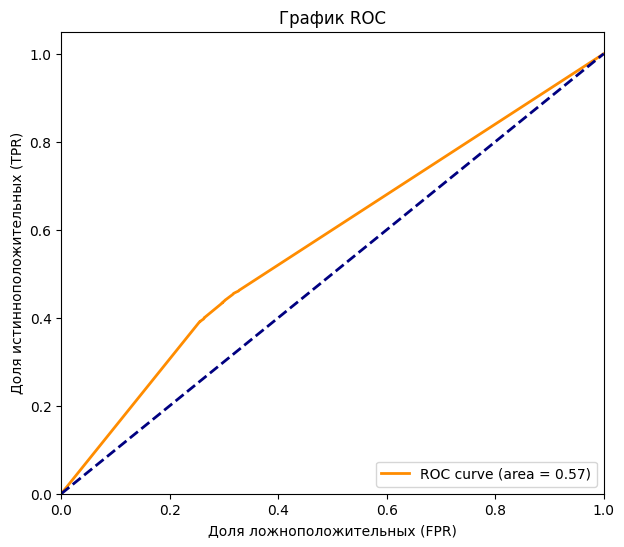

Построение матрицы ошибок для лучшей модели


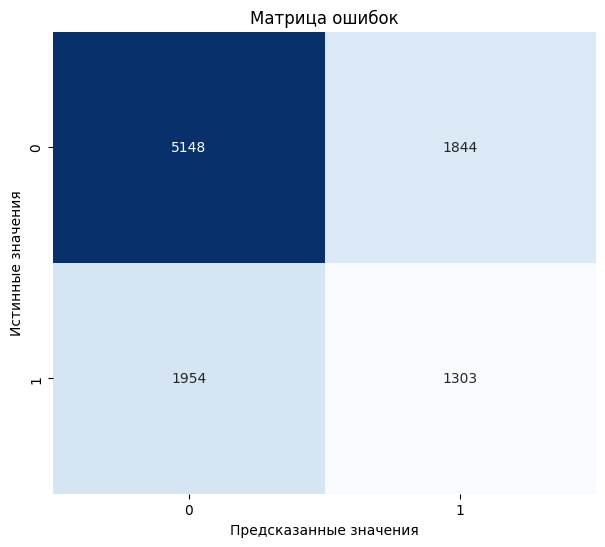

Важность признаков


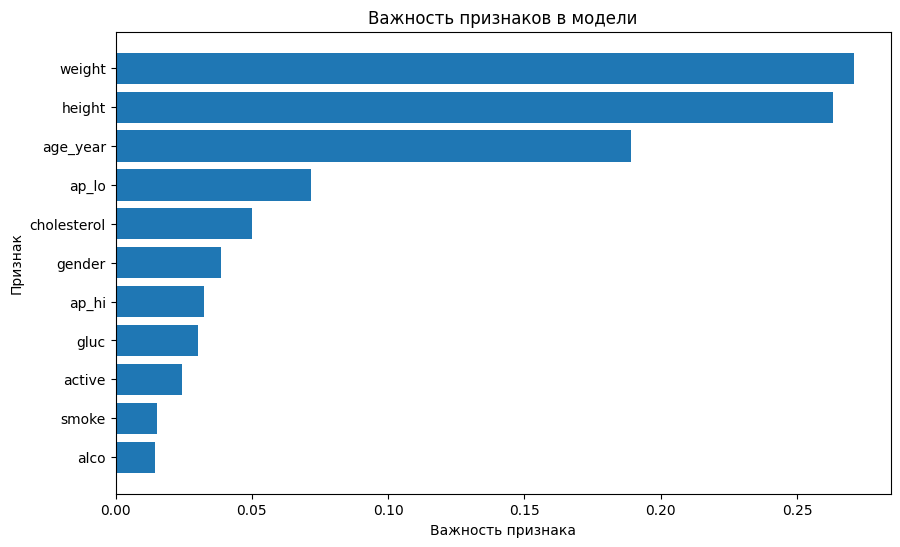

In [64]:
score_model(base_tree, X_test, y_test)

Для дерева решений без гиперпараметров значение метрик на валидационных данных и тестовых равны 0.5561 и 0.5725 соотвественно.

####Обучение дерева решений с использованием гиперпараметров

In [65]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [66]:
tree_param = {
        'max_depth': range(2, 20),
        'max_features': range(2, 20)}

In [67]:
%%time
random_search_tree = RandomizedSearchCV(
    estimator=tree,
    param_distributions=tree_param,
    n_iter=10,
    cv=5,
    scoring='roc_auc')

random_search_tree.fit(X_train, y_train)
tree_best = random_search_tree.best_estimator_
best_score_tree = round(random_search_tree.best_score_, 4)

print('Лучшая модель и её параметры:\n\n', tree_best)
print('Параметры лучшей модели:\n', random_search_tree.best_params_)
print(f'\n\nМетрика ROC-AUC на кросс-валидационной выборке:', best_score_tree)

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=5, max_features=7, random_state=42)
Параметры лучшей модели:
 {'max_features': 7, 'max_depth': 5}


Метрика ROC-AUC на кросс-валидационной выборке: 0.6857
CPU times: user 2.12 s, sys: 4.98 ms, total: 2.13 s
Wall time: 2.12 s


Оценка ROC-AUC на тестовых данных для лучшей модели
Значение ROC-AUC на тестовых данных: 0.6807


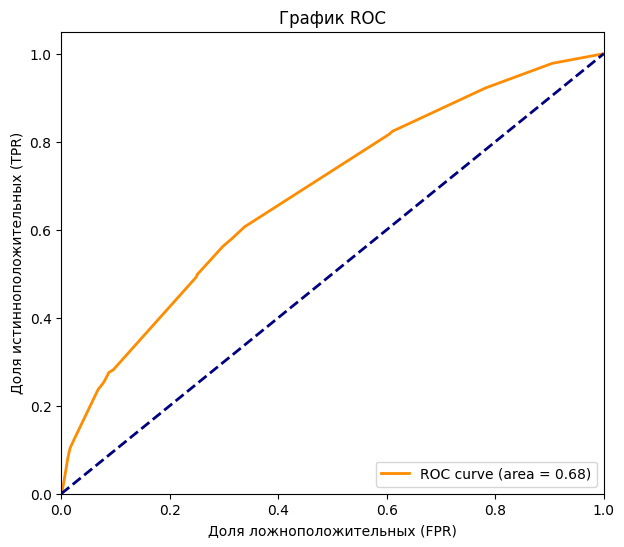

Построение матрицы ошибок для лучшей модели


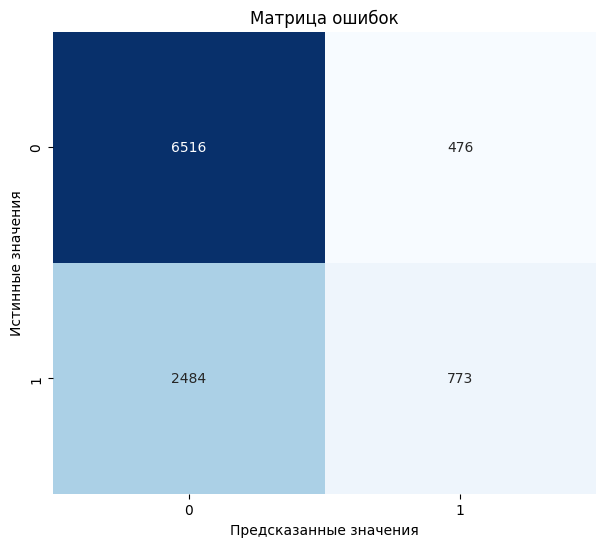

Важность признаков


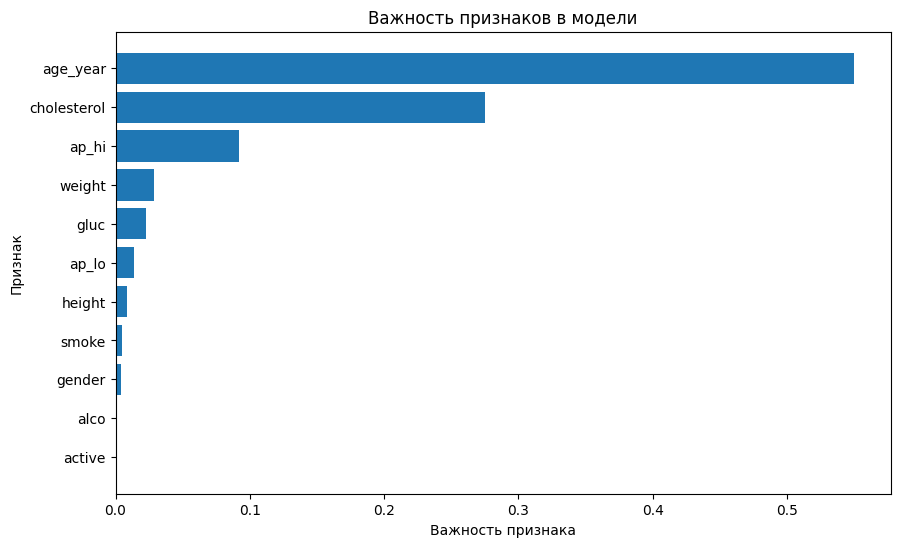

In [68]:
score_model(tree_best, X_test, y_test)

Для дерева решений значение метрик на валидационных данных и тестовых равны 0.68406 и 0.6860 соотвественно.

###Обучение случайного леса

####Обучение случайного леса без гиперпараметров

In [69]:
base_forest = RandomForestClassifier()

In [70]:
scores_forest = cross_val_score(base_forest, X_train, y_train, cv=5, scoring='roc_auc')

In [71]:
mean_cv_auc_forest = scores_forest.mean()
std_cv_auc_forest  = scores_forest.std()
print(f"Средняя метрика ROC-AUC на кросс-валидации: {mean_cv_auc_forest:.4f}, std: {std_cv_auc_forest:.4f}")

Средняя метрика ROC-AUC на кросс-валидации: 0.6405, std: 0.0053


In [72]:
base_forest.fit(X_train, y_train)

RandomForestClassifier()

Оценка ROC-AUC на тестовых данных для лучшей модели
Значение ROC-AUC на тестовых данных: 0.6443


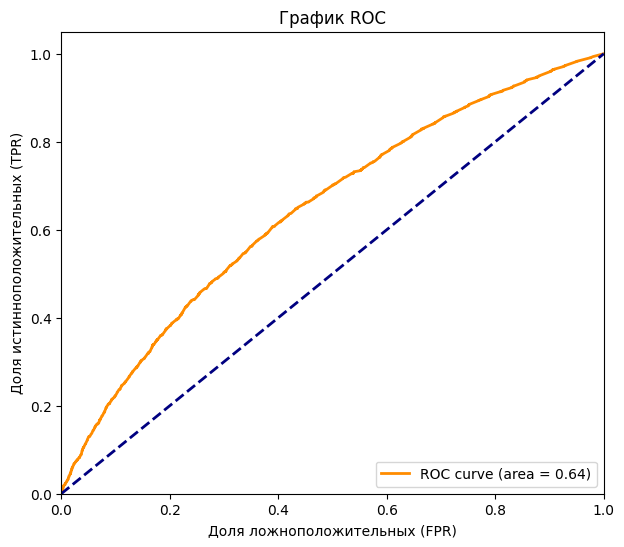

Построение матрицы ошибок для лучшей модели


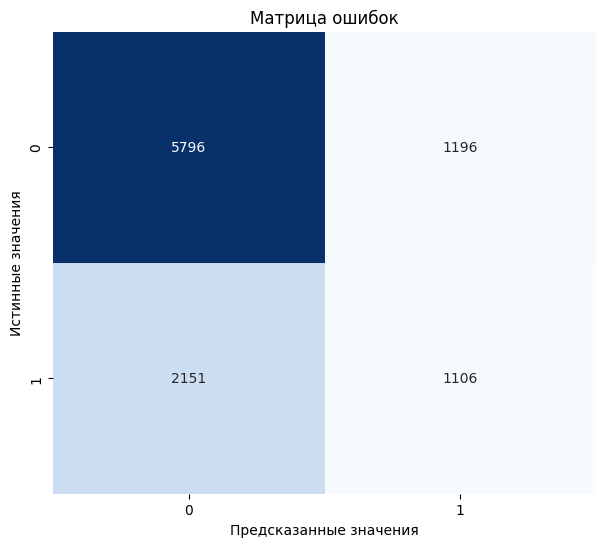

Важность признаков


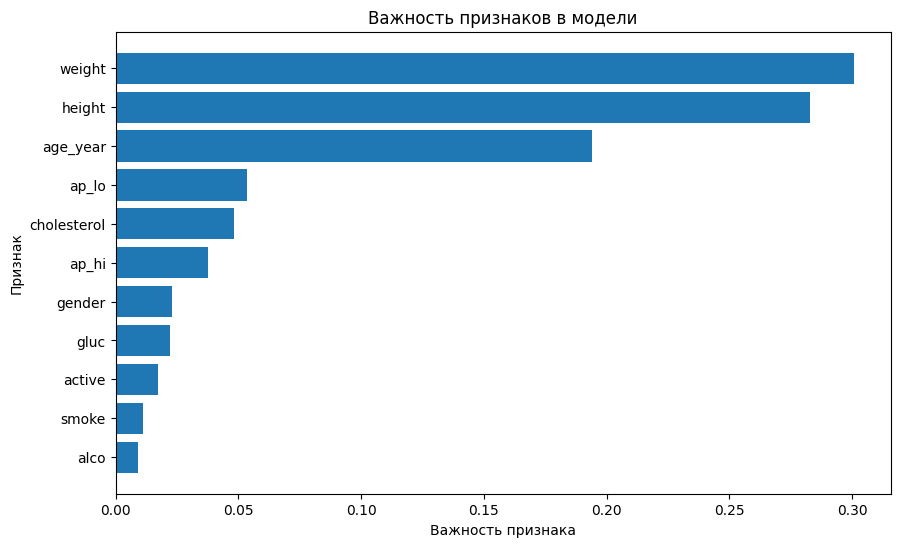

In [73]:
score_model(base_forest, X_test, y_test)

####Обучение случайного леса с гиперпараметрами

In [74]:
forest = RandomForestClassifier()

In [75]:
forest_param = {
        'n_estimators': [100, 150, 200],
        'bootstrap': [True, False],
        'max_depth': range(10, 20)}

In [ ]:
%%time
random_search_forest = RandomizedSearchCV(
    estimator=forest,
    param_distributions=forest_param,
    n_iter=10,
    cv=5,
    scoring='roc_auc')

random_search_forest.fit(X_train, y_train)
forest_best = random_search_tree.best_estimator_
best_score_forest = round(random_search_tree.best_score_, 4)

print('Лучшая модель и её параметры:\n\n', forest_best)
print('Параметры лучшей модели:\n', random_search_forest.best_params_)
print(f'\n\nМетрика ROC-AUC на кросс-валидационной выборке:', best_score_forest)

In [ ]:
score_model(forest_best, X_test, y_test)

##Градиентный бустинг

###Градиентный бустинг без гиперпараметров

Для обучения моделей градиентного бустинга выберем самые популярные LightGBM и XGBoost.

####Обучение LightGBM

In [ ]:
model_boost_1 = LGBMClassifier()

In [ ]:
scores_boost_1 = cross_val_score(model_boost_1, X_train, y_train, cv=5, scoring='roc_auc')

In [ ]:
mean_cv_auc_boost_1 = scores_boost_1.mean()
std_cv_auc_boost_1  = scores_boost_1.std()
print(f"Средняя метрика ROC-AUC на кросс-валидации: {mean_cv_auc_boost_1:.4f}, std: {std_cv_auc_boost_1:.4f}")

In [ ]:
model_boost_1.fit(X_train, y_train)

In [ ]:
score_model(model_boost_1, X_test, y_test)

In [ ]:
y_pred_boost = model_boost_1.predict(X_test)

In [ ]:
precision_boost_1 = precision_score(y_test, y_pred_boost)
print(f"Precision: {precision_boost_1:.4f}")

In [ ]:
recall_boost_1 = recall_score(y_test, y_pred_boost)
print(f"Recall: {recall_boost_1:.4f}")

Как видно, в данную модель больший вклад вносит признак веса.

####Обучение XGBoost

In [ ]:
model_boost_2 = xgb.XGBClassifier()

In [ ]:
scores_boost_2 = cross_val_score(model_boost_2, X_train, y_train, cv=5, scoring='roc_auc')

In [ ]:
mean_cv_auc_boost_2 = scores_boost_2.mean()
std_cv_auc_boost_2  = scores_boost_2.std()
print(f"Средняя метрика ROC-AUC на кросс-валидации: {mean_cv_auc_boost_1:.4f}, std: {std_cv_auc_boost_1:.4f}")

In [ ]:
model_boost_2.fit(X_train, y_train)

In [ ]:
preds_boost_2 = model_boost_2.predict(X_test)

In [ ]:
precision_boost_2 = precision_score(y_test, preds_boost_2)
print(f"Precision: {precision_boost_2:.4f}")

In [ ]:
recall_boost_2 = recall_score(y_test, preds_boost_2)
print(f"Recall: {recall_boost_2:.4f}")

In [ ]:
score_model(model_boost_2, X_test, y_test)

Как видно из графика, наибольший вклад в модель вносит холестерол.

In [ ]:
models = ['LightGBM', 'XGBoost']

result = {
    'Precision':[precision_boost_1, precision_boost_2],
    'Recall': [recall_boost_1, recall_boost_2]}

df_results = pd.DataFrame(result, index=models)
df_results

Из двух моделей лучшие метрики у LightGBM. Подберем по сетке гиперпараметры.

####Обучение LightGBM с гиперпараметрами

In [ ]:
boost = LGBMClassifier()

In [ ]:
params_boost = {
    'objective': ['binary'],
    'metric': ['binary_logloss'],
    'num_leaves':range(10, 15),
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': range(45, 60)
}

In [ ]:
%%time
random_search_boost = RandomizedSearchCV(
    estimator=boost,
    param_distributions=params_boost,
    n_iter=10,
    cv=5,
    scoring='roc_auc')

random_search_boost.fit(X_train, y_train)
boost_best = random_search_boost.best_estimator_
best_score_boost = round(random_search_boost.best_score_, 4)

print('Лучшая модель и её параметры:\n\n', boost_best)
print('Параметры лучшей модели:\n', random_search_boost.best_params_)
print(f'\n\nМетрика ROC-AUC на кросс-валидационной выборке:', best_score_boost)

In [ ]:
score_model(boost_best, X_test, y_test)

Наибольший вклад вносит показатель вес.

###Общие выводы

В случае использования гиперпараметров метрики модели становятся лучше. Но для всех моделей не удалось получить метрики выше ROC-AUC выше 0.8. В связи с этим в дальнейшем нелбходимо отобрать несколько лучших моделей с лучшими гиперпараметрами и перерабоать данные. Возможно создать синтетически новые данные. На данный момент все модели допускают ошибку второго рода, что в случае нашей цели является недопустимым.

Проект требует дальнейшей доработки.

In [ ]:
print('Код не упал!')